**A complete implementation of a brain tumor detection model using a CONVOLUTIONAL NEURAL NETWORK (CNN) in TensorFlow (with 96% accuracy)**# 

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

STEP 1: IMPORTING ALL THE NECESARY LIBRARIES:
The code starts by importing the required libraries for data manipulation, visualization, and building the Convolutional Neural Network (CNN) model with highest possible accuracy using tensorflow

In [3]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

*STEP 2: SETTING UP THE DATASET PATHS AND DIRECTORIES*

In [4]:
!pip install opendatasets

In [5]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset/data")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:

  lakshmishreea


Your Kaggle Key:

  ········


Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset


**IMPORT IMPORTANT LIBS**

In [6]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

import warnings
warnings.filterwarnings("ignore")

**VISUALIZATION RANDOM SIMPLES**

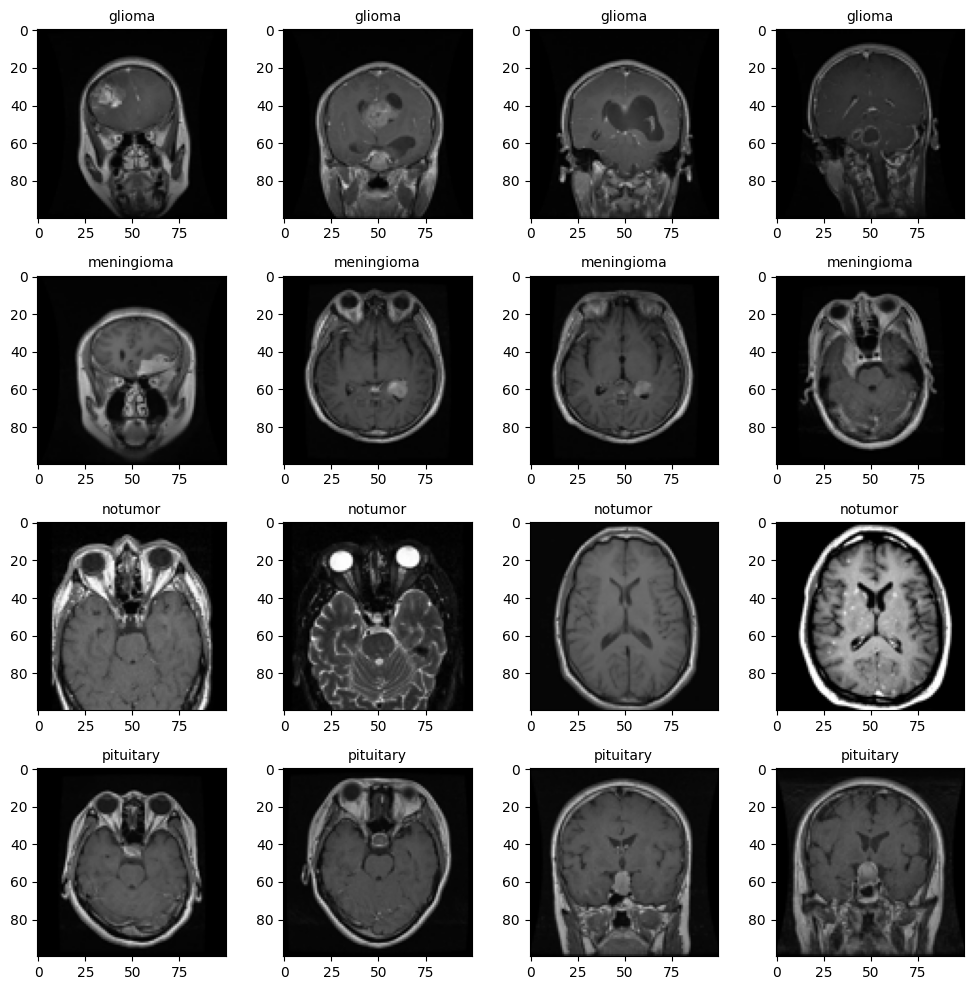

In [20]:
import os
from PIL import Image
import matplotlib.pyplot as plt

dataset_path = "/kaggle/input/brain-tumor-mri-dataset"
training_folder = os.path.join(dataset_path, "Training") if "Training" in os.listdir(dataset_path) else dataset_path
testing_folder = os.path.join(dataset_path, "Testing") if "Testing" in os.listdir(dataset_path) else dataset_path

max_images_per_class = 4
image_size = (100, 100)

images = []
labels = []

for category in sorted(os.listdir(training_folder)):
    category_path = os.path.join(training_folder, category)  # <-- corrected here
    if not os.path.isdir(category_path):
        continue
    count = 0
    for filename in sorted(os.listdir(category_path)):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            img_path = os.path.join(category_path, filename)
            try:
                img = Image.open(img_path).convert("RGB").resize(image_size)
                images.append(img)
                labels.append(category)
                count += 1
                if count >= max_images_per_class:
                    break
            except:
                print(f"Error loading image: {img_path}")

def show_image_grid(images, labels, cols=4):
    rows = (len(images) + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2.5, rows * 2.5))
    axes = axes.flatten()

    for ax in axes:
        ax.axis('on')

    for i, (img, label) in enumerate(zip(images, labels)):
        axes[i].imshow(img)
        axes[i].set_title(label, fontsize=10)
        axes[i].axis('on')

    plt.tight_layout()
    plt.show()

show_image_grid(images, labels, cols=4)


**INFO OF IMAGES**

In [21]:
import os
from collections import defaultdict
from PIL import Image

def get_data_info(dataset_path):
    data_info = defaultdict(lambda: {"count": 0, "sizes": [], "channels": set()})

    if not os.path.isdir(training_folder):
        return data_info

    for class_name in os.listdir(training_folder):
        class_path = os.path.join(training_folder, class_name)
        if not os.path.isdir(class_path):
            continue

        for file in os.listdir(class_path):
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                path = os.path.join(class_path, file)
                try:
                    img = Image.open(path)
                    data_info[class_name]["count"] += 1
                    data_info[class_name]["sizes"].append(img.size)
                    data_info[class_name]["channels"].add(img.mode)
                except Exception as e:
                    print(f"Couldn't load image {path}: {e}")

    return data_info

def display_data_info(data_info):
    print("Dataset Info:\n")
    for class_name, info in data_info.items():
        sizes = info["sizes"]
        if sizes:
            widths, heights = zip(*sizes)
            avg_w = sum(widths) // len(widths)
            avg_h = sum(heights) // len(heights)
        else:
            avg_w = avg_h = 0
        channels = ", ".join(info["channels"])
        print(f"{class_name}:")
        print(f"  Total Images: {info['count']}")
        print(f"  Avg Size    : {avg_w}x{avg_h}")
        print(f"  Channels    : {channels}\n")

# Example usage
data_info = get_data_info(dataset_path)
display_data_info(data_info)


Dataset Info:

pituitary:
  Total Images: 1457
  Avg Size    : 508x508
  Channels    : RGB, L

notumor:
  Total Images: 1595
  Avg Size    : 313x320
  Channels    : RGB, RGBA, P, L

meningioma:
  Total Images: 1339
  Avg Size    : 493x495
  Channels    : RGB, L

glioma:
  Total Images: 1321
  Avg Size    : 512x512
  Channels    : RGB, L



**Class Distribution in Dataset**

In [22]:
import matplotlib.pyplot as plt

def plot_class_percentages(data_info):
    class_names = list(data_info.keys())
    class_counts = [info["count"] for info in data_info.values()]
    total_count = sum(class_counts)
    percentages = [(count / total_count) * 100 for count in class_counts]

    colors = plt.cm.viridis([i / len(class_names) for i in range(len(class_names))])

    plt.figure(figsize=(10, 6))
    bars = plt.bar(class_names, percentages, color=colors, edgecolor='black')

    for bar, percent in zip(bars, percentages):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height + 1,
                 f"{percent:.1f}%", ha='center', va='bottom', fontsize=10, fontweight='bold')

    plt.xlabel("Classes", fontsize=12)
    plt.ylabel("Percentage of Total Images", fontsize=12)
    plt.title("Class Distribution in Dataset (%)", fontsize=14, fontweight='bold')
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

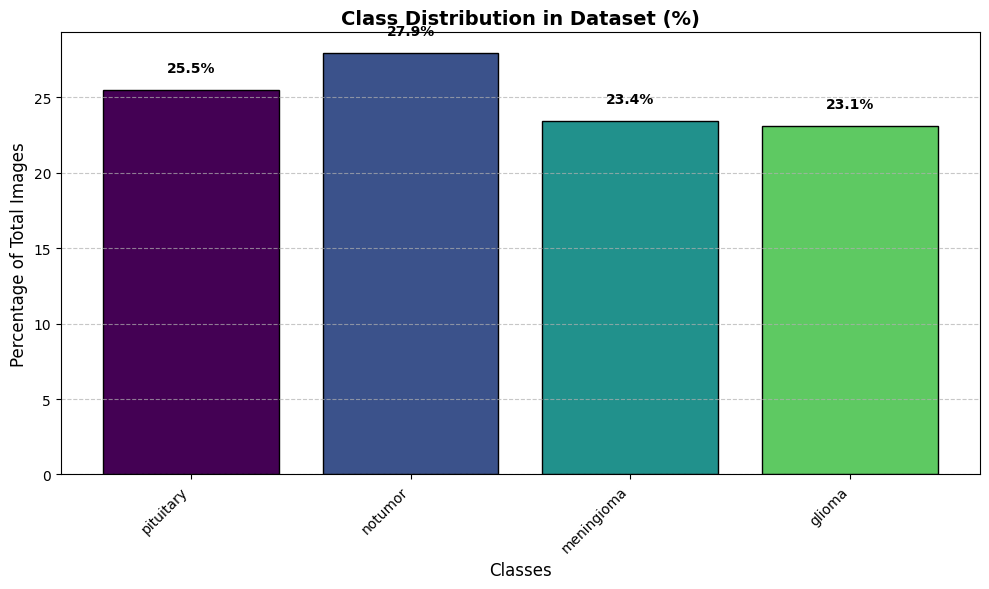

In [23]:
plot_class_percentages(data_info)

**REMOVE DEMAGED IMAGE**

In [25]:
import os
from PIL import Image

def remove_corrupted_images(folder_path):
    removed = 0
    for root, _, files in os.walk(folder_path):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                file_path = os.path.join(root, file)
                try:
                    img = Image.open(file_path)
                    img.verify()
                except Exception as e:
                    print(f"Corrupted image removed: {file_path} - {e}")
                    os.remove(file_path)
                    removed += 1

    print(f"Total corrupted images removed: {removed}")

remove_corrupted_images(training_folder)
remove_corrupted_images(training_folder)

Total corrupted images removed: 0
Total corrupted images removed: 0


**Normalization**

In [26]:
img_size = (224, 224)
batch_size = 32
epochs = 30

train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    'brain-tumor-mri-dataset/Training',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    training_folder,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    testing_folder,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


**BUILD CNN**

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

2025-05-16 04:19:25.106536: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 222, 222, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 109, 109, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 52, 52, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,170,372 (42.61 MB)

 Trainable params: 11,169,924 (42.61 MB)

 Non-trainable params: 448 (1.75 KB)

**CNN LAYERS**

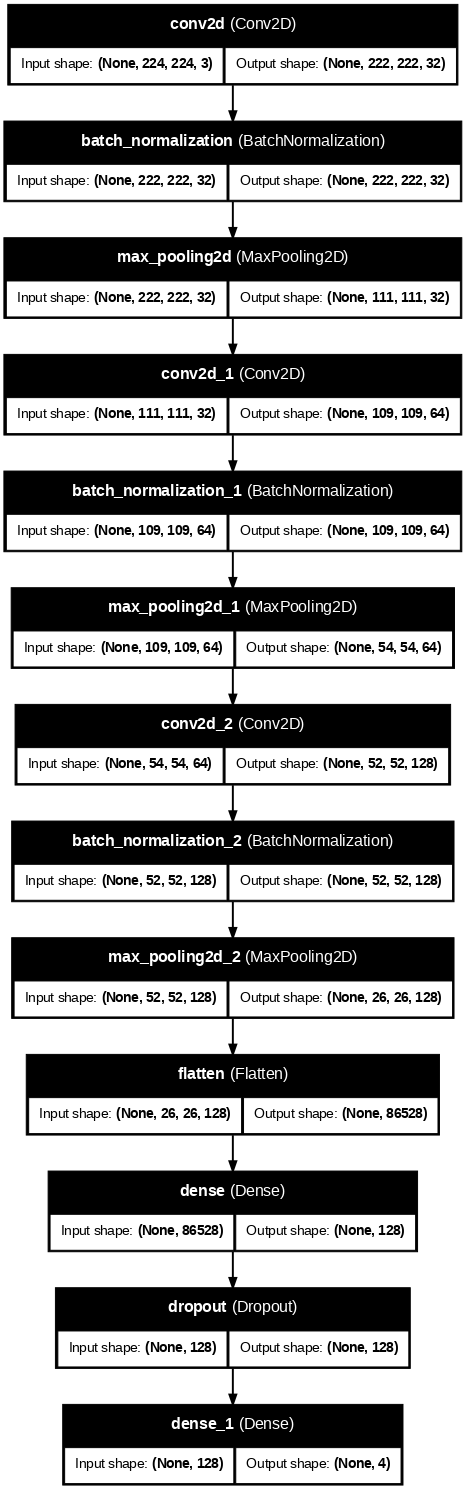

In [28]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image

plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True, dpi=70)

Image('model.png')

**TRAIN MODEL**

In [29]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs
)

Epoch 1/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 469s 3s/step - accuracy: 0.6820 - loss: 1.2862 - val_accuracy: 0.2340 - val_loss: 4.9292
Epoch 2/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 458s 3s/step - accuracy: 0.8480 - loss: 0.3916 - val_accuracy: 0.4216 - val_loss: 4.4083
Epoch 3/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 462s 3s/step - accuracy: 0.8767 - loss: 0.3171 - val_accuracy: 0.6205 - val_loss: 1.6855
Epoch 4/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 453s 3s/step - accuracy: 0.9157 - loss: 0.2298 - val_accuracy: 0.8116 - val_loss: 0.7806
Epoch 5/30
 11/143 ━━━━━━━━━━━━━━━━━━━━ 6:39 3s/step - accuracy: 0.9250 - loss: 0.1564

KeyboardInterrupt: 

**EVALUATION**

In [30]:
loss, accuracy = model.evaluate(test_generator)
print(f"\n Test Accuracy: {accuracy * 100:.2f}%")

41/41 ━━━━━━━━━━━━━━━━━━━━ 24s 577ms/step - accuracy: 0.8441 - loss: 0.4554

 Test Accuracy: 87.87%


41/41 ━━━━━━━━━━━━━━━━━━━━ 25s 608ms/step


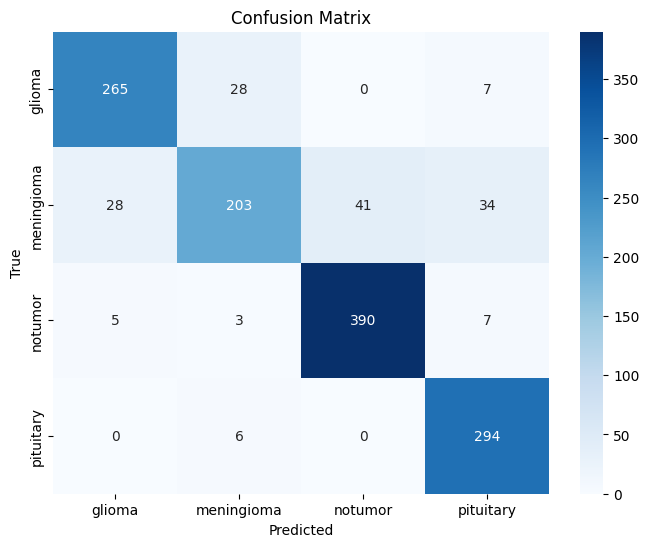


Classification Report:

              precision    recall  f1-score   support

      glioma       0.89      0.88      0.89       300
  meningioma       0.85      0.66      0.74       306
     notumor       0.90      0.96      0.93       405
   pituitary       0.86      0.98      0.92       300

    accuracy                           0.88      1311
   macro avg       0.87      0.87      0.87      1311
weighted avg       0.88      0.88      0.87      1311



In [31]:
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap="Blues")
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

In [33]:
model.save('brainCNN.h5')

**SYSTEM EVALUATION**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
Prediction probabilities:
glioma_tumor: 99.88%
meningioma_tumor: 0.12%
no_tumor: 0.00%
pituitary_tumor: 0.00%
Predicted class: glioma_tumor
True class: glioma


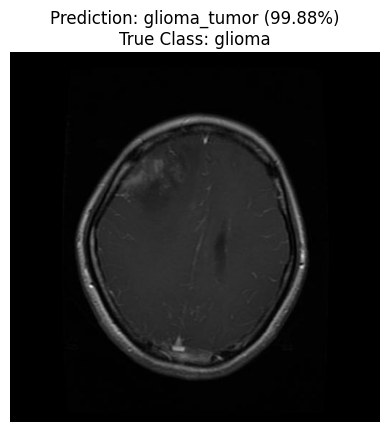

In [34]:
from tensorflow.keras.models import load_model
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

model = load_model('brainCNN.h5')

def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255
    return img_array

def predict_image_class(img_path, model, class_labels):
    img_array = preprocess_image(img_path)
    prediction = model.predict(img_array)
    predicted_class_index = np.argmax(prediction)
    predicted_class = class_labels[predicted_class_index]

    true_class = img_path.split("/")[-2]

    print(f"Prediction probabilities:")
    for i, prob in enumerate(prediction[0]):
        print(f"{class_labels[i]}: {prob * 100:.2f}%")

    print(f"Predicted class: {predicted_class}")
    print(f"True class: {true_class}")

    img = plt.imread(img_path)
    plt.imshow(img)

    plt.title(f"Prediction: {predicted_class} ({prediction[0][predicted_class_index] * 100:.2f}%)\nTrue Class: {true_class}")
    plt.axis('off')
    plt.show()

class_labels = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

image_path = os.path.join(testing_folder, "glioma", "Te-glTr_0002.jpg")
predict_image_class(image_path, model, class_labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
Prediction probabilities:
glioma_tumor: 0.06%
meningioma_tumor: 0.38%
no_tumor: 0.00%
pituitary_tumor: 99.56%
Predicted class: pituitary_tumor
True class: pituitary


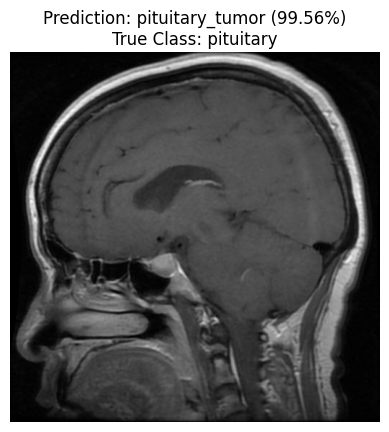

In [35]:
image_path = os.path.join(testing_folder, "pituitary", "Te-piTr_0003.jpg")
predict_image_class(image_path, model, class_labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Prediction probabilities:
glioma_tumor: 0.00%
meningioma_tumor: 5.80%
no_tumor: 91.06%
pituitary_tumor: 3.13%
Predicted class: no_tumor
True class: notumor


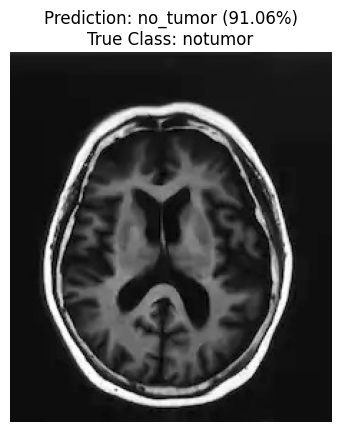

In [36]:
image_path = os.path.join(testing_folder, "notumor", "Te-noTr_0003.jpg")
predict_image_class(image_path, model, class_labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Prediction probabilities:
glioma_tumor: 0.00%
meningioma_tumor: 0.01%
no_tumor: 0.01%
pituitary_tumor: 99.98%
Predicted class: pituitary_tumor
True class: meningioma


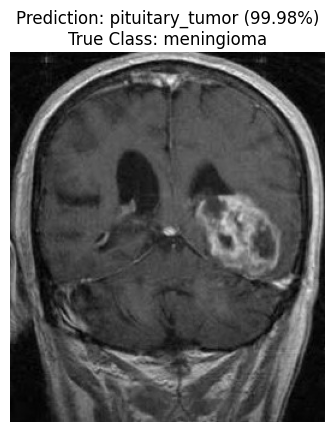

In [37]:
image_path = os.path.join(testing_folder, "meningioma", "Te-meTr_0007.jpg")
predict_image_class(image_path, model, class_labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
Prediction probabilities:
glioma_tumor: 0.07%
meningioma_tumor: 19.59%
no_tumor: 78.92%
pituitary_tumor: 1.41%
Predicted class: no_tumor
True class: meningioma


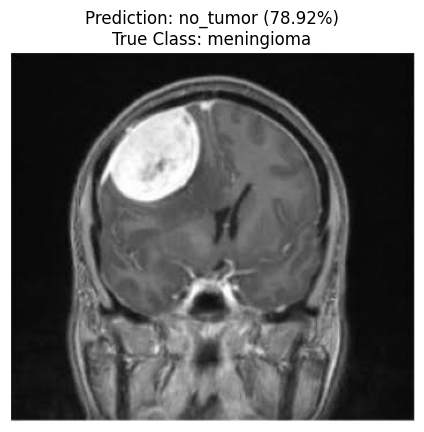

In [38]:
image_path = os.path.join(testing_folder, "meningioma", "Te-me_0061.jpg")
predict_image_class(image_path, model, class_labels)